<a href="https://colab.research.google.com/github/AlexShefY/Style-Transfer/blob/main/Style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
import math
import numpy as np
import torch
import torchvision
import transformers

device = torch.device("cuda")

image_processor = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
])
model = transformers.ResNetModel.from_pretrained("microsoft/resnet-50").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [4]:
import matplotlib.pyplot as plt
import PIL

def content_loss(a, b):
    diff2 = (a - b)
    diff2 = diff2 * diff2
    return torch.sum(diff2) / 2

def gram(layer):
    shape = layer.shape
    features = layer.reshape((shape[0], shape[1], shape[2] * shape[3]))
    g = torch.matmul(features, features.transpose(1, 2))
    return g

def style_loss(a, b):
    a_gram, b_gram = gram(a), gram(b)
    diff2 = (a_gram - b_gram)
    diff2 = diff2 * diff2
    return torch.sum(diff2) / 2 / a.shape[1] / a.shape[2] / a.shape[3]

In [5]:
for name, param in model.named_parameters():
    param.requires_grad = False

In [6]:
def apply_style_transfer(content_path, style_path, iterations, checkpoints, w1, w2, idxs1, idxs2):
    content_target = PIL.Image.open(content_path)
    style_target = PIL.Image.open(style_path)

    img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)

    with torch.no_grad():
        content_inputs = image_processor(content_target).unsqueeze(0).to(device)
        style_inputs = image_processor(style_target).unsqueeze(0).to(device)
        content_outputs = model(content_inputs, output_hidden_states = True)
        style_outputs = model(style_inputs, output_hidden_states = True)

    optimiser = torch.optim.Adam([img], lr = 1e-3, eps = 1e-12)
    for i in range(iterations + 1):
        optimiser.zero_grad()
        img_outputs = model(img, output_hidden_states = True)
        loss = 0
        for k, j in enumerate(idxs1):
          loss += w1[k] * content_loss(img_outputs.hidden_states[j], content_outputs.hidden_states[j])
        for k, j in enumerate(idxs2):
          loss += w2[k] * style_loss(img_outputs.hidden_states[j], style_outputs.hidden_states[j])
        if i % checkpoints == 0:
            print(loss.item())
            plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
            plt.show()
        loss.backward()
        optimiser.step()

<ipython-input-6-5ddc65160df3>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)


382077728.0


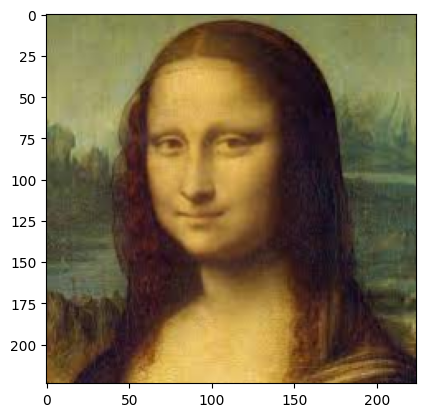

4626093.5


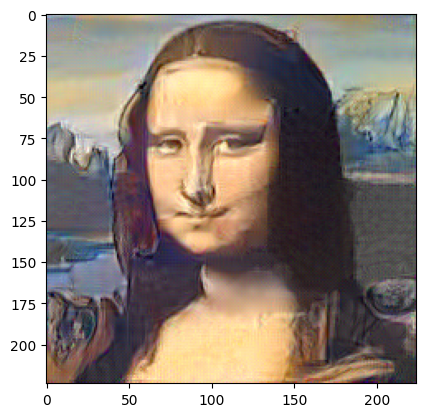

3213120.0


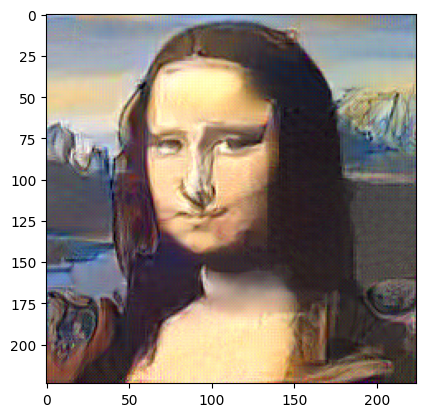

In [7]:
apply_style_transfer("mona_lisa.jpeg", "time2.jpeg", 5000, 2500, [1, 1], [500] * 5, [3, 4], [0, 1, 2, 3, 4])

**Let's try another parameters:**

<ipython-input-6-5ddc65160df3>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)


334823296.0


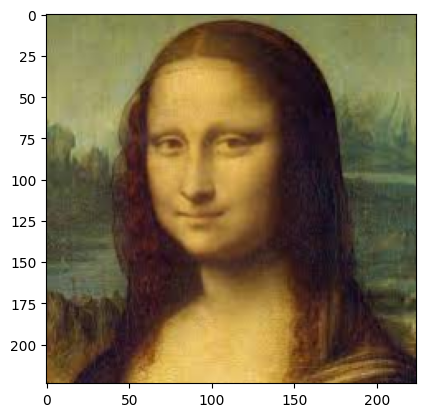

1645193.25


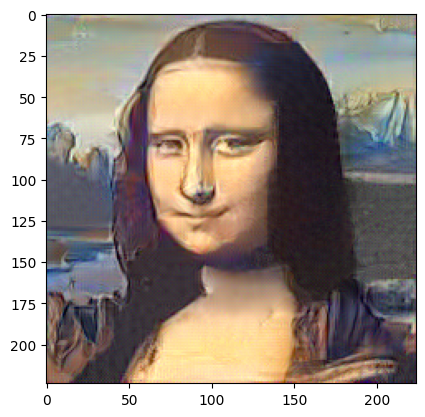

908178.3125


In [8]:
apply_style_transfer("mona_lisa.jpeg", "time2.jpeg", 5000, 2500, [1] * 2, [500] * 3, [3, 4], [0, 1, 2])

Loss was less, but visually it changed a little

<ipython-input-6-5ddc65160df3>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)


381992768.0


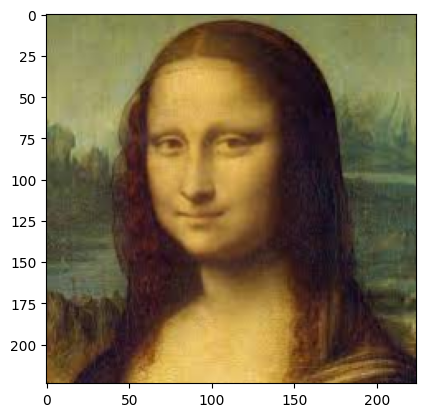

4668317.0


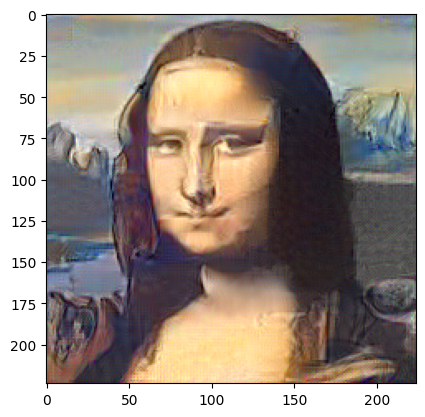

3290909.0


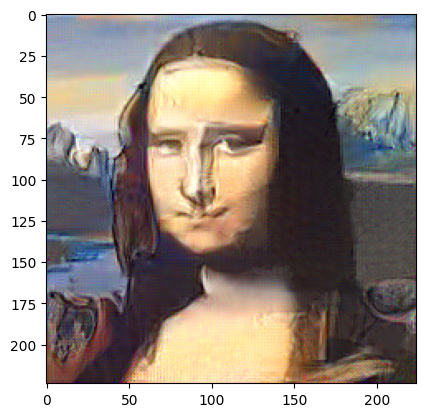

In [9]:
apply_style_transfer("mona_lisa.jpeg", "time2.jpeg", 5000, 2500, [1] * 2, [500] * 4, [3, 4], [0, 1, 2, 3])

<ipython-input-6-5ddc65160df3>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(image_processor(content_target).unsqueeze(0), requires_grad=True, device=device)


669646592.0


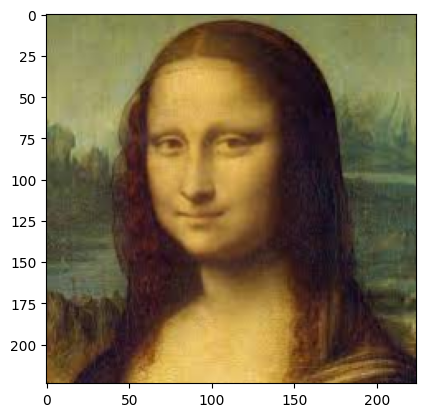

3157935.25


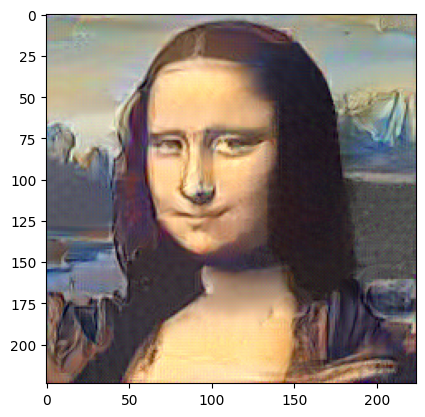

1704682.25


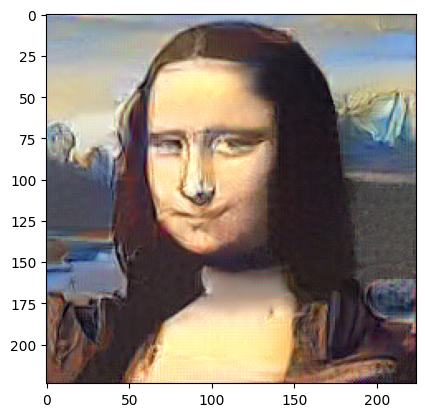

1272596.75


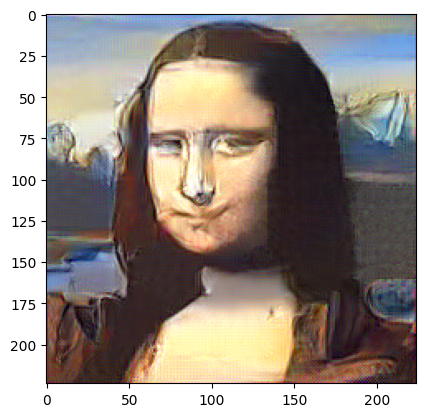

1106912.0


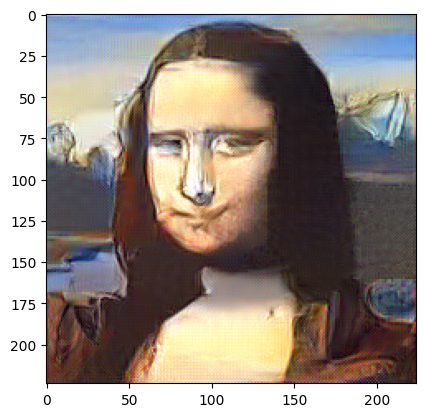

In [10]:
apply_style_transfer("mona_lisa.jpeg", "time2.jpeg", 10000, 2500, [1] * 2, [1000] * 3, [3, 4], [0, 1, 2])